In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mxnet import image as mximg
import mxnet as mx
from tqdm import tqdm
from mxnet import nd
from sklearn.model_selection import train_test_split
from mxnet.gluon import nn
import h5py
%matplotlib inline

# Data Structure

In [2]:
data_dir = "D:\dog_data\dogbreed\std_dogs\Images"    #这个方法使用斯坦福提供的数据集   用这些数据集去训练网络
for dir_name in os.listdir(data_dir):
    src = os.path.join(data_dir, dir_name)
    dst = os.path.join(data_dir, dir_name[10:].lower())
    os.rename(src, dst)

# Image Preprocess 

- size: > 224 
- normalized: mean = [0.485, 0.456, 0.406],  std = [0.229, 0.224, 0.225]
- shape:  RGB images of shape (N x 3 x H x W)

https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html#mxnet.gluon.model_zoo

In [3]:
preprocess_list = [
    lambda img: img.astype("float32")/255,
    mx.image.ForceResizeAug((224, 224)),
    mx.image.ColorNormalizeAug(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    lambda img: nd.transpose(img,(2,0,1))
]

def image_preprocess(img):
    for f in preprocess_list:
        img = f(img)
    return img

# Data Loader

In [4]:
def transform(img, label):
    return image_preprocess(img), label

def load_data(data_dir, load_batch_size = 32, f_trans=transform):
    imgs = mx.gluon.data.vision.ImageFolderDataset(data_dir, transform=transform)
    data = mx.gluon.data.DataLoader(imgs, load_batch_size, last_batch="keep")
    return data

In [5]:
data = load_data("D:\dog_data\dogbreed\std_dogs\Images")

# Pretrained Net Loader

In [7]:
ctx = mx.cpu()
resnet50_v2 = mx.gluon.model_zoo.vision.resnet50_v2(pretrained=True, ctx=ctx)

# Feature Extraction From Pretrained Net

In [8]:
def extract_features(net, data, ctx):
    rst_X, rst_y = [], []
    for X, y in tqdm(data):
        Xi = net.features(X.as_in_context(ctx))
        rst_X.append(Xi.asnumpy())
        rst_y.append(y.asnumpy())
    return np.concatenate(rst_X, axis=0), np.concatenate(rst_y, axis=0) 

In [9]:
X_all, y_all = extract_features(resnet50_v2, data, ctx)

100%|██████████████████████████████████████| 644/644 [1:18:57<00:00,  7.36s/it]


In [10]:
print ("X_all shape: ", X_all.shape)
print ("y_all shape: ", y_all.shape)

X_all shape:  (20580, 2048)
y_all shape:  (20580,)


# Data Iterator            特征提取之后开始做训练前的准备

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.1)

# dataset
dataset_train = mx.gluon.data.ArrayDataset(nd.array(X_train), nd.array(y_train))
dataset_val = mx.gluon.data.ArrayDataset(nd.array(X_val), nd.array(y_val))
dataset_all = mx.gluon.data.ArrayDataset(nd.array(X_all), nd.array(y_all))

# data itet
batch_size = 128
data_iter_train = mx.gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)
data_iter_val = mx.gluon.data.DataLoader(dataset_val, batch_size)
data_iter_all = mx.gluon.data.DataLoader(dataset_all, batch_size)

# Build Model

In [32]:
ctx = mx.cpu()
def get_net(ctx):

    net = nn.Sequential()
    with net.name_scope():
        net.add(nn.Dense(256, activation='relu'))
        net.add(nn.Dropout(0.5))
        net.add(nn.Dense(120))

    net.initialize(ctx=ctx)
    return net

# Training

In [33]:
def accuracy(output, labels):
    return nd.mean(nd.argmax(output, axis=1) == labels).asscalar()

def evaluate(net, data_iter):
    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    loss, acc, n = 0., 0., 0.
    steps = len(data_iter)
    for data, label in data_iter:
        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
        loss += nd.mean(softmax_cross_entropy(output, label)).asscalar()
    return loss/steps, acc/steps

In [34]:
def train(net, data_iter_train, data_iter_val, ctx, 
          epochs=50, lr=0.01, mome=0.9, wd=1e-4, lr_decay=0.5, lr_period=20):

    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
#     trainer = mx.gluon.Trainer(net.collect_params(),  'sgd', {'learning_rate': lr, 'momentum': mome, 
#                                       'wd': wd})
    trainer = mx.gluon.Trainer(net.collect_params(),  'adam', {'learning_rate': lr, 'wd': wd})
    
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        steps = len(data_iter_train)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for X, y in data_iter_train:

            X, y = X.as_in_context(ctx), y.as_in_context(ctx)

            with mx.autograd.record():
                out = net(X)
                loss = softmax_cross_entropy(out, y)

            loss.backward()
            trainer.step(batch_size)

            train_loss += nd.mean(loss).asscalar()


            train_acc += accuracy(out, y)
    
        if data_iter_val:
            val_loss, val_acc = evaluate(net, data_iter_val)
            train_loss_list.append(train_loss/steps)
            val_loss_list.append(val_loss)
            print("Epoch %d. loss: %.4f, acc: %.2f%%, val_loss %.4f, val_acc %.2f%%" % (
                epoch+1, train_loss/steps, train_acc/steps*100, val_loss, val_acc*100))
        
    return train_loss_list, val_loss_list

In [35]:
net = get_net(ctx)
train_loss_list, val_loss_list = train(net, data_iter_train, data_iter_val, ctx, epochs=150, lr=0.0001, \
      mome=0.9, wd=0, lr_decay=0.5, lr_period=20)

Epoch 1. loss: 4.3396, acc: 9.73%, val_loss 3.5302, val_acc 42.48%
Epoch 2. loss: 3.0110, acc: 34.66%, val_loss 2.0830, val_acc 69.29%
Epoch 3. loss: 2.0278, acc: 52.04%, val_loss 1.3466, val_acc 78.02%
Epoch 4. loss: 1.5509, acc: 60.39%, val_loss 1.0336, val_acc 80.46%
Epoch 5. loss: 1.2891, acc: 65.65%, val_loss 0.8663, val_acc 81.46%
Epoch 6. loss: 1.1288, acc: 68.72%, val_loss 0.7630, val_acc 82.56%
Epoch 7. loss: 1.0272, acc: 70.97%, val_loss 0.7042, val_acc 82.61%
Epoch 8. loss: 0.9461, acc: 72.60%, val_loss 0.6615, val_acc 82.33%
Epoch 9. loss: 0.8823, acc: 73.86%, val_loss 0.6330, val_acc 83.24%
Epoch 10. loss: 0.8380, acc: 74.96%, val_loss 0.6001, val_acc 83.39%
Epoch 11. loss: 0.7945, acc: 76.71%, val_loss 0.5840, val_acc 83.25%
Epoch 12. loss: 0.7557, acc: 77.38%, val_loss 0.5625, val_acc 83.93%
Epoch 13. loss: 0.7321, acc: 77.88%, val_loss 0.5566, val_acc 83.12%
Epoch 14. loss: 0.7004, acc: 78.91%, val_loss 0.5457, val_acc 84.16%
Epoch 15. loss: 0.6883, acc: 78.83%, val_los

KeyboardInterrupt: 

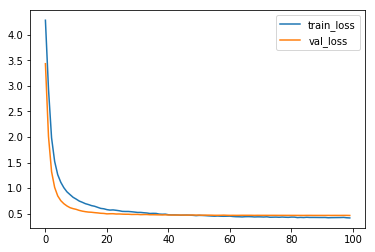

In [24]:
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")
plt.legend()

(0, 0.6)

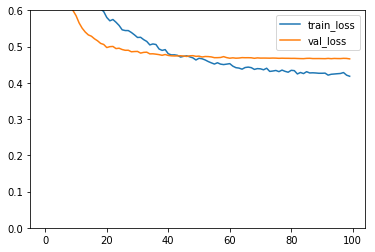

In [27]:
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")
plt.legend()
plt.ylim([0,0.6])

# Training Using All Data

In [28]:
net = get_net(ctx)
train_loss_list, val_loss_list = train(net, data_iter_all, None, ctx, epochs=100, lr=0.0001, \
      mome=0.9, wd=0, lr_decay=0.5, lr_period=20)

# Testing

In [29]:
with h5py.File('D:\dog_data\dogbreed/resnet50_v2_pretrained_Xy.h5', 'r') as f:
    X_test_resnet50_v2 = np.array(f['X_test_resnet50_v2'])
    
print ("X_test Size: ", X_test_resnet50_v2.shape)

X_test Size:  (10357, 2048)


In [30]:
out_softmax = nd.softmax(net(nd.array(X_test_resnet50_v2).as_in_context(ctx)))

synsets = mx.gluon.data.vision.ImageFolderDataset("D:\dog_data\dogbreed/train_gy").synsets
ids = sorted(os.listdir("D:\dog_data\dogbreed/test_gy/0/"))
ids = [i[:-4] for i in ids]

df = pd.DataFrame(out_softmax.asnumpy())
df.columns = synsets
df["id"] = ids
df = df[["id"]+synsets]

In [31]:
df.to_csv('D:\dog_data\dogbreed/pred3.csv', index=None)